In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys,os
sys.path.append("./src/")
import requests
import graph_tool.all as gt
import pickle
import GenModel as GM
from Converter import *
from preprocess import preprocess
import summary_stats_all as SS
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import ast
import random

# Retrieve Dataset

In [3]:
response = requests.get("https://networks.skewed.de/api/nets?full=True").json()

In [4]:
net_names = requests.get("https://networks.skewed.de/api/nets").json()

Network selection criteria:
1. Largest component size in [MIN=50,MAX=20000]
2. NOT bipartite
3. NOT Multilayer
4. NOT Multiple type of edges
5. In 5 categories: Online Social, Economic, Technological, Biological and Informational


In [2]:
def eligible_network(response,name,net=None):
    if 'Multilayer' in response[name]['tags']:
        return False;
    if 'Multigraph' in response[name]['tags']:
        return False;
    if net == None:
        network_info = response[name]['analyses']
    else:
        network_info = response[name]['analyses'][net]
    lc = network_info['num_vertices']*network_info['largest_component_fraction']
    if lc < MIN or lc > MAX:
        return False;
    if network_info['is_bipartite']:
        return False;
    n = 0
    for tag in response[name]['tags']:
        if tag in eligible_type:
            n += 1
    if n == len(eligible_type):
        return True;
    return False;

## Social & Online

In [6]:
MIN = 50
MAX = 20000
eligible_type = ["Social","Online"]

In [21]:
eligible_name = []
for name in net_names:
    if len(response[name]['nets']) == 1:
        if eligible_network(response,name):
            eligible_name.append(name)
    else:
        for net in response[name]['nets']:
            if eligible_network(response,name,net):
                eligible_name.append(name+'/'+net)

In [22]:
#We notice a lot networks under one name which are collected in the same way from same source 
#so we only choose one network among similar networks in our analysis
delete = False
names = eligible_name.copy()
for name in names:
    if name == "ego_social/gplus_100466178325794757407" or name == "ego_social/facebook_0":
        delete = True
    if delete:
        eligible_name.remove(name)
    if name == "ego_social/gplus_118379821279745746467" or name == "ego_social/facebook_3437":
        delete = False

In [294]:
with open("../Data/Social/fname.list","wb") as f:
    pickle.dump(eligible_name,f)

In [19]:
#Download networks we selected
#Print potenitial edge weight(if any) for follow-up analysis
graphs = {}
for f in eligible_name:
    try:
        g = gt.collection.ns[f]
        
        
        name = f.split("/")
        fname = f.replace("/","")
        g.save("./Data/Social/" +fname +".xml.gz")
        if "Weighted" in response[name[0]]['tags']:
            graphs[f] = [k for k in g.ep.keys()]
        else:
            graphs[f] = None
    except Exception as e:
        print(e)
        print(f," failed! Next try.")
        ;

In [20]:
graphs

{'advogato': ['weight'],
 'anybeat': None,
 'bitcoin_alpha': ['rating', 'time'],
 'bitcoin_trust': ['rating', 'time'],
 'ego_social/facebook_combined': None,
 'ego_social/gplus_100129275726588145876': None,
 'ego_social/gplus_100329698645326486178': None,
 'elec': None,
 'facebook_friends': None,
 'facebook_organizations/S1': None,
 'facebook_organizations/S2': None,
 'facebook_organizations/M1': None,
 'facebook_organizations/M2': None,
 'facebook_organizations/L1': None,
 'facebook_organizations/L2': None,
 'fediverse': None,
 'inploid': None,
 'qa_user/mathoverflow_c2q': None,
 'qa_user/mathoverflow_c2a': None}

## Economic

In [39]:
MIN = 50
MAX = 20000
eligible_type = ["Economic"]

In [40]:
eligible_name = []
for name in net_names:
    if len(response[name]['nets']) == 1:
        if eligible_network(response,name):
            eligible_name.append(name)
    else:
        for net in response[name]['nets']:
            if eligible_network(response,name,net):
                eligible_name.append(name+'/'+net)

In [42]:
#product space is a projection network from a bipartite network so we also remove this network
delete = False
names = eligible_name.copy()
for name in names:
    if name in ["faculty_hiring_us/domain_applied_sciences","faculty_hiring_us/domain_social_sciences","product_space/HS"]:
        delete = True
    if delete:
        eligible_name.remove(name)
    if name in ["faculty_hiring_us/domain_medicine_and_health","faculty_hiring_us/field_veterinary_medical_sciences",'product_space/SITC']:
        delete = False
    

In [268]:
with open("./Data/Economic/fname.list","wb") as f:
    pickle.dump(eligible_name,f)

In [43]:
graphs = {}
for f in eligible_name:
    try:
        g = gt.collection.ns[f]
        
        
        name = f.split("/")
        fname = f.replace("/","")
        g.save("./Data/Economic/" +fname +".xml.gz")
        if "Weighted" in response[name[0]]['tags']:
            graphs[f] = [k for k in g.ep.keys()]
        else:
            graphs[f] = None
    except Exception as e:
        print(e)
        print(f," failed! Next try.")
        ;

In [44]:
print(graphs)

{'faculty_hiring/computer_science': ['rank', 'gender'], 'faculty_hiring/business': ['rank', 'gender'], 'faculty_hiring/history': ['rank', 'gender'], 'faculty_hiring_us/academia': ['total', 'men', 'women'], 'faculty_hiring_us/domain_natural_sciences': ['total', 'men', 'women'], 'un_migrations': ['migration_1990_total', 'migration_1990_male', 'migration_1990_female', 'migration_1995_total', 'migration_1995_male', 'migration_1995_female', 'migration_2000_total', 'migration_2000_male', 'migration_2000_female', 'migration_2005_total', 'migration_2005_male', 'migration_2005_female', 'migration_2010_total', 'migration_2010_male', 'migration_2010_female', 'migration_2015_total', 'migration_2015_male', 'migration_2015_female']}


## Technological

In [55]:
eligible_type = ["Technological"]
eligible_name = []
for name in net_names:
    if len(response[name]['nets']) == 1:
        if eligible_network(response,name):
            eligible_name.append(name)
    else:
        for net in response[name]['nets']:
            if eligible_network(response,name,net):
                eligible_name.append(name+'/'+net)
len(eligible_name)

776

In [57]:
delete = False
names = eligible_name.copy()
for name in names:
    if name in ["caida_as/20050704",'gnutella/06','route_views/19971109',"software_dependencies/jung-j"]:
        delete = True
    if delete:
        eligible_name.remove(name)
    if name in ["caida_as/20040105",'gnutella/09',"route_views/20000102","software_dependencies/junit"]:
        delete = False
    

In [273]:
with open("./Data/Technological/fname.list","wb") as f:
    pickle.dump(eligible_name,f)

In [274]:
graphs = {}
for f in eligible_name:
    try:
        g = gt.collection.ns[f]
        
        
        name = f.split("/")
        fname = f.replace("/","")
        g.save("./Data/Technological/" +fname +".xml.gz")
        if "Weighted" in response[name[0]]['tags']:
            graphs[f] = [k for k in g.ep.keys()]
        else:
            graphs[f] = None
    except Exception as e:
        print(e)
        print(f," failed! Next try.")
        ;

In [275]:
graphs

{'caida_as/20070917': None,
 'gnutella/04': None,
 'jung': None,
 'power': None,
 'route_views/19971108': None,
 'software_dependencies/jdk': None}

## Biological

In [59]:
eligible_type = ["Biological"]
eligible_name = []
for name in net_names:
    if len(response[name]['nets']) == 1:
        if eligible_network(response,name):
            eligible_name.append(name)
    else:
        for net in response[name]['nets']:
            if eligible_network(response,name,net):
                eligible_name.append(name+'/'+net)
                break;
len(eligible_name)

25

In [277]:
with open("./Data/Biological/fname.list","wb") as f:
    pickle.dump(eligible_name,f)

In [278]:
graphs = {}
for f in eligible_name:
    try:
        g = gt.collection.ns[f]
        
        
        name = f.split("/")
        fname = f.replace("/","")
        g.save("./Data/Biological/" +fname +".xml.gz")
        if "Weighted" in response[name[0]]['tags']:
            graphs[f] = [k for k in g.ep.keys()]
        else:
            graphs[f] = None
    except Exception as e:
        print(e)
        print(f," failed! Next try.")
        ;

In [279]:
graphs

{'blumenau_drug': ['tau',
  'severity',
  'weight',
  'color',
  'gender',
  'patients_norm',
  'RRI^F',
  'patients',
  'tau_norm',
  'RRI^M'],
 'budapest_connectome/all_20k': ['fiber_count_mean',
  'fiber_length_mean',
  'fractional_anisotropy_mean',
  'electrical_connectivity_median',
  'fiber_count_median',
  'fiber_length_median',
  'fractional_anisotropy_median',
  'occurences'],
 'celegans_2019/male_chemical': ['connectivity'],
 'celegans_interactomes/wi2007': None,
 'celegans_metabolic': None,
 'celegansneural': ['value'],
 'cintestinalis': ['depth'],
 'collins_yeast': None,
 'ecoli_transcription/v1.0': None,
 'foodweb_baywet': ['weight'],
 'foodweb_little_rock': None,
 'fresh_webs/AkatoreA': None,
 'fullerene_structures/C1500': None,
 'human_brains/BNU1_0025864_1_DTI_AAL': None,
 'interactome_figeys': None,
 'interactome_pdz': None,
 'interactome_stelzl': None,
 'interactome_vidal': None,
 'interactome_yeast': None,
 'kegg_metabolic/aae': None,
 'messal_shale': ['certainty', '

## Informational

In [280]:
eligible_type = ["Informational"]
eligible_name = []
for name in net_names:
    if len(response[name]['nets']) == 1:
        if eligible_network(response,name):
            eligible_name.append(name)
    else:
        for net in response[name]['nets']:
            if eligible_network(response,name,net):
                eligible_name.append(name+'/'+net)
                break;
len(eligible_name)

11

In [282]:
with open("./Data/Informational/fname.list","wb") as f:
    pickle.dump(eligible_name,f)

In [283]:
graphs = {}
for f in eligible_name:
    try:
        g = gt.collection.ns[f]
        
        
        name = f.split("/")
        fname = f.replace("/","")
        g.save("./Data/Informational/" +fname +".xml.gz")
        if "Weighted" in response[name[0]]['tags']:
            graphs[f] = [k for k in g.ep.keys()]
        else:
            graphs[f] = None
    except Exception as e:
        print(e)
        print(f," failed! Next try.")
        ;

In [284]:
graphs

{'adjnoun': None,
 'bible_nouns': ['weight'],
 'dblp_cite': None,
 'foldoc': ['weight'],
 'google': None,
 'polblogs': None,
 'polbooks': None,
 'webkb/webkb_wisconsin_link1': ['weight'],
 'wiki_science': None,
 'wikipedia_link/as': None,
 'word_adjacency/darwin': None}

In [77]:
f = "wikipedia_link/as"
g = gt.collection.ns[f]
fname = f.replace("/","")
g.save("./Data/Informational/" +fname +".xml.gz")

# Fit Community Detection Model
* For all networks collected from previous step, preprocess networks first

* Fit all five community detection methods to these networks

* Some methods fail in some networks due to convergence issue

* Store all partition results as a dictionary with method name as key and corresponding partition result as value. Results are stored in dataname.par for one dataset

* Examples of fitting models are shown in Tutorial.ipynb

In [ ]:
from preprocess import preprocess
from Converter import *

# Classify Community Structure Types

## Social & Online

In [3]:
df = pd.DataFrame({'Name': [],'vp_name':[],'ep_name':[],'Directed': [], 'N': [], 'E':[],
                   'Community Size-SBM':[],'Community Size-SBM_DC':[],'Community Size-Louvain':[],
                   'Community Size-Infomap':[],'Community Size-Spectral':[],'Community Size-DNGR':[],
                   'Community Eligible Size-SBM':[],'Community Eligible Size-SBM_DC':[],'Community Eligible Size-Louvain':[],
                   'Community Eligible Size-Infomap':[],'Community Eligible Size-Spectral':[],'Community Eligible Size-DNGR':[],
                   'Description Length-SBM':[],'Description Length-SBM_DC':[],'Description Length-Louvain':[],
                   'Description Length-Infomap':[],'Description Length-Spectral':[],'Description Length-DNGR':[],
                   'Modularity-SBM':[],'Modularity-SBM_DC':[],'Modularity-Louvain':[],
                   'Modularity-Infomap':[],'Modularity-Spectral':[],'Modularity-DNGR':[],
                   'Interaction Fraction-SBM':[],'Interaction Fraction-SBM_DC':[],'Interaction Fraction-Louvain':[],
                   'Interaction Fraction-Infomap':[],'Interaction Fraction-Spectral':[],'Interaction Fraction-DNGR':[],
                   'Interaction Fraction All-SBM':[],'Interaction Fraction All-SBM_DC':[],'Interaction Fraction All-Louvain':[],
                   'Interaction Fraction All-Infomap':[],'Interaction Fraction All-Spectral':[],'Interaction Fraction All-DNGR':[]})
df = df.astype('object')
df.to_csv('./Outputs/Social/statistics.csv',index = False)

In [4]:
%%time
df = SS.stats(df,"Social","facebook_friends", vp_name = "title",ep_name = None)
df = SS.stats(df,"Social","ego_socialgplus_100329698645326486178", vp_name = "title",ep_name = None)
df = SS.stats(df,"Social","facebook_organizationsL1", vp_name = "title",ep_name = None)
df = SS.stats(df,"Social","facebook_organizationsM1", vp_name = "title",ep_name = None)
df = SS.stats(df,"Social","facebook_organizationsM2", vp_name = "title",ep_name = None)
df = SS.stats(df,"Social","facebook_organizationsS1", vp_name = "title",ep_name = None)
df = SS.stats(df,"Social","facebook_organizationsS2", vp_name = "title",ep_name = None)
df = SS.stats(df,"Social","facebook_organizationsL2", vp_name = "title",ep_name = None)
#fediverse does not have spectral partition
# df = SS.stats(df,"Social","fediverse", vp_name = "title",ep_name = None,has_sbm = True,has_sbm_dc = True,has_louvain = True,has_info = True,has_spec=True)
df = SS.stats(df,"Social","anybeat", vp_name = "title",ep_name = None,reverse_dir = True)
df = SS.stats(df,"Social","qa_usermathoverflow_c2a", vp_name = "title",ep_name = None)
df = SS.stats(df,"Social","inploid", vp_name = "title",ep_name = None)

df.to_csv('./Outputs/Social/statistics.csv',index = False)


CPU times: user 5h 54min 57s, sys: 4h 55min 21s, total: 10h 50min 19s
Wall time: 10h 52min 19s


## Economic

In [6]:
df = pd.DataFrame({'Name': [],'vp_name':[],'ep_name':[],'Directed': [], 'N': [], 'E':[],
                   'Community Size-SBM':[],'Community Size-SBM_DC':[],'Community Size-Louvain':[],
                   'Community Size-Infomap':[],'Community Size-Spectral':[],'Community Size-DNGR':[],
                   'Community Eligible Size-SBM':[],'Community Eligible Size-SBM_DC':[],'Community Eligible Size-Louvain':[],
                   'Community Eligible Size-Infomap':[],'Community Eligible Size-Spectral':[],'Community Eligible Size-DNGR':[],
                   'Description Length-SBM':[],'Description Length-SBM_DC':[],'Description Length-Louvain':[],
                   'Description Length-Infomap':[],'Description Length-Spectral':[],'Description Length-DNGR':[],
                   'Modularity-SBM':[],'Modularity-SBM_DC':[],'Modularity-Louvain':[],
                   'Modularity-Infomap':[],'Modularity-Spectral':[],'Modularity-DNGR':[],
                   'Interaction Fraction-SBM':[],'Interaction Fraction-SBM_DC':[],'Interaction Fraction-Louvain':[],
                   'Interaction Fraction-Infomap':[],'Interaction Fraction-Spectral':[],'Interaction Fraction-DNGR':[],
                   'Interaction Fraction All-SBM':[],'Interaction Fraction All-SBM_DC':[],'Interaction Fraction All-Louvain':[],
                   'Interaction Fraction All-Infomap':[],'Interaction Fraction All-Spectral':[],'Interaction Fraction All-DNGR':[]})
df = df.astype('object')
df.to_csv('./Outputs/Economic/statistics.csv',index = False)

In [7]:
%%time
#faculty_hiring_usacademia does not have spectral partition
# df = SS.stats(df,"Economic","faculty_hiring_usacademia", vp_name = "title",ep_name = "total",has_sbm = True,has_sbm_dc = True,has_louvain = True,has_info = True,has_spec=True)
df = SS.stats(df,"Economic","faculty_hiring_usdomain_natural_sciences", vp_name = "title",ep_name = "total")
df = SS.stats(df,"Economic","faculty_hiringbusiness", vp_name = "title",ep_name = None)
df = SS.stats(df,"Economic","faculty_hiringcomputer_science", vp_name = "title",ep_name = None)
df = SS.stats(df,"Economic","faculty_hiringhistory", vp_name = "title",ep_name = None)
df = SS.stats(df,"Economic","un_migrations", vp_name = "title",ep_name = "migration_2015_total")
df.to_csv('./Outputs/Economic/statistics.csv',index = False)



CPU times: user 12.6 s, sys: 1.56 s, total: 14.2 s
Wall time: 14.2 s


## Technological

In [9]:
df = pd.DataFrame({'Name': [],'vp_name':[],'ep_name':[],'Directed': [], 'N': [], 'E':[],
                   'Community Size-SBM':[],'Community Size-SBM_DC':[],'Community Size-Louvain':[],
                   'Community Size-Infomap':[],'Community Size-Spectral':[],'Community Size-DNGR':[],
                   'Community Eligible Size-SBM':[],'Community Eligible Size-SBM_DC':[],'Community Eligible Size-Louvain':[],
                   'Community Eligible Size-Infomap':[],'Community Eligible Size-Spectral':[],'Community Eligible Size-DNGR':[],
                   'Description Length-SBM':[],'Description Length-SBM_DC':[],'Description Length-Louvain':[],
                   'Description Length-Infomap':[],'Description Length-Spectral':[],'Description Length-DNGR':[],
                   'Modularity-SBM':[],'Modularity-SBM_DC':[],'Modularity-Louvain':[],
                   'Modularity-Infomap':[],'Modularity-Spectral':[],'Modularity-DNGR':[],
                   'Interaction Fraction-SBM':[],'Interaction Fraction-SBM_DC':[],'Interaction Fraction-Louvain':[],
                   'Interaction Fraction-Infomap':[],'Interaction Fraction-Spectral':[],'Interaction Fraction-DNGR':[],
                   'Interaction Fraction All-SBM':[],'Interaction Fraction All-SBM_DC':[],'Interaction Fraction All-Louvain':[],
                   'Interaction Fraction All-Infomap':[],'Interaction Fraction All-Spectral':[],'Interaction Fraction All-DNGR':[]})
df = df.astype('object')
df.to_csv('./Outputs/Technological/statistics.csv',index = False)

In [10]:
%%time
df = SS.stats(df,"Technological","caida_as20070917", vp_name = "title",ep_name = None,reverse_dir = True)
df = SS.stats(df,"Technological","gnutella04", vp_name = "title",ep_name = None,reverse_dir = True)
df = SS.stats(df,"Technological","jung", vp_name = "title",ep_name = None,reverse_dir = True)
df = SS.stats(df,"Technological","power", vp_name = "title",ep_name = None)
df = SS.stats(df,"Technological","route_views19971108", vp_name = "title",ep_name = None)
df = SS.stats(df,"Technological","software_dependenciesjdk", vp_name = "title",ep_name = None,reverse_dir = True)

df.to_csv('./Outputs/Technological/statistics.csv',index = False)



CPU times: user 1h 14min 12s, sys: 43min 18s, total: 1h 57min 31s
Wall time: 1h 58min 30s


## Biological

In [12]:
df = pd.DataFrame({'Name': [],'vp_name':[],'ep_name':[],'Directed': [], 'N': [], 'E':[],
                   'Community Size-SBM':[],'Community Size-SBM_DC':[],'Community Size-Louvain':[],
                   'Community Size-Infomap':[],'Community Size-Spectral':[],'Community Size-DNGR':[],
                   'Community Eligible Size-SBM':[],'Community Eligible Size-SBM_DC':[],'Community Eligible Size-Louvain':[],
                   'Community Eligible Size-Infomap':[],'Community Eligible Size-Spectral':[],'Community Eligible Size-DNGR':[],
                   'Description Length-SBM':[],'Description Length-SBM_DC':[],'Description Length-Louvain':[],
                   'Description Length-Infomap':[],'Description Length-Spectral':[],'Description Length-DNGR':[],
                   'Modularity-SBM':[],'Modularity-SBM_DC':[],'Modularity-Louvain':[],
                   'Modularity-Infomap':[],'Modularity-Spectral':[],'Modularity-DNGR':[],
                   'Interaction Fraction-SBM':[],'Interaction Fraction-SBM_DC':[],'Interaction Fraction-Louvain':[],
                   'Interaction Fraction-Infomap':[],'Interaction Fraction-Spectral':[],'Interaction Fraction-DNGR':[],
                   'Interaction Fraction All-SBM':[],'Interaction Fraction All-SBM_DC':[],'Interaction Fraction All-Louvain':[],
                   'Interaction Fraction All-Infomap':[],'Interaction Fraction All-Spectral':[],'Interaction Fraction All-DNGR':[]})
df = df.astype('object')
df.to_csv('./Outputs/Biological/statistics.csv',index = False)

In [14]:
%%time
df = SS.stats(df,"Biological","blumenau_drug", vp_name = "title",ep_name = 'weight')
df = SS.stats(df,"Biological","celegans_metabolic", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","celegansneural", vp_name = "title",ep_name = "value")
df = SS.stats(df,"Biological","cintestinalis", vp_name = "title",ep_name = "depth")
df = SS.stats(df,"Biological","foodweb_little_rock", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","fresh_websAkatoreA", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","fullerene_structuresC1500", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","human_brainsBNU1_0025864_1_DTI_AAL", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","interactome_figeys", vp_name = "title",reverse_dir = True,ep_name = None)
df = SS.stats(df,"Biological","interactome_pdz", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","interactome_stelzl", vp_name = "title",reverse_dir = True,ep_name = None)
df = SS.stats(df,"Biological","messal_shale", vp_name = "title",reverse_dir = True,ep_name = None)
df = SS.stats(df,"Biological","yeast_transcription", vp_name = "title",ep_name = None)

df = SS.stats(df,"Biological","ecoli_transcriptionv1.0", vp_name = "title",ep_name = None)

df = SS.stats(df,"Biological","budapest_connectomeall_20k", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","celegans_2019male_chemical", vp_name = "title",ep_name = "connectivity")
df = SS.stats(df,"Biological","celegans_interactomeswi2007", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","collins_yeast", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","interactome_vidal", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","interactome_yeast", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","kegg_metabolicaae", vp_name = "title",ep_name = None)
df = SS.stats(df,"Biological","tree-of-life394", vp_name = "title",ep_name = None)


df.to_csv('./Outputs/Biological/statistics.csv',index = False)

CPU times: user 1min 16s, sys: 27.7 s, total: 1min 43s
Wall time: 1min 44s


## Informational

In [16]:
df = pd.DataFrame({'Name': [],'vp_name':[],'ep_name':[],'Directed': [], 'N': [], 'E':[],
                   'Community Size-SBM':[],'Community Size-SBM_DC':[],'Community Size-Louvain':[],
                   'Community Size-Infomap':[],'Community Size-Spectral':[],'Community Size-DNGR':[],
                   'Community Eligible Size-SBM':[],'Community Eligible Size-SBM_DC':[],'Community Eligible Size-Louvain':[],
                   'Community Eligible Size-Infomap':[],'Community Eligible Size-Spectral':[],'Community Eligible Size-DNGR':[],
                   'Description Length-SBM':[],'Description Length-SBM_DC':[],'Description Length-Louvain':[],
                   'Description Length-Infomap':[],'Description Length-Spectral':[],'Description Length-DNGR':[],
                   'Modularity-SBM':[],'Modularity-SBM_DC':[],'Modularity-Louvain':[],
                   'Modularity-Infomap':[],'Modularity-Spectral':[],'Modularity-DNGR':[],
                   'Interaction Fraction-SBM':[],'Interaction Fraction-SBM_DC':[],'Interaction Fraction-Louvain':[],
                   'Interaction Fraction-Infomap':[],'Interaction Fraction-Spectral':[],'Interaction Fraction-DNGR':[],
                   'Interaction Fraction All-SBM':[],'Interaction Fraction All-SBM_DC':[],'Interaction Fraction All-Louvain':[],
                   'Interaction Fraction All-Infomap':[],'Interaction Fraction All-Spectral':[],'Interaction Fraction All-DNGR':[]})
df = df.astype('object')
df.to_csv('./Outputs/Informational/statistics.csv',index = False)

In [17]:
%%time
df = SS.stats(df,"Informational","adjnoun", vp_name = "title",ep_name = None)
df = SS.stats(df,"Informational","polblogs", vp_name = "title",ep_name = None,reverse_dir = True)
df = SS.stats(df,"Informational","polbooks", vp_name = "title",ep_name = None)
df = SS.stats(df,"Informational","webkbwebkb_wisconsin_link1", vp_name = "title",ep_name = 'weight')
df = SS.stats(df,"Informational","wiki_science", vp_name = "title",ep_name = None)
df = SS.stats(df,"Informational","word_adjacencydarwin", vp_name = "title",ep_name = None)
df = SS.stats(df,"Informational","bible_nouns", vp_name = "title",ep_name = 'weight')
#google does not have spectral partition
# df = SS.stats(df,"Informational","google", vp_name = "title",ep_name = None,has_sbm = True,has_sbm_dc = True,has_louvain = True,has_info = True,has_spec=True)
df = SS.stats(df,"Informational","dblp_cite", vp_name = "title",ep_name = None,reverse_dir = True)





df.to_csv('./Outputs/Informational/statistics.csv',index = False)

CPU times: user 1h 54min 39s, sys: 1h 33min 26s, total: 3h 28min 6s
Wall time: 3h 29min 36s


## Overall statistics

We combine all networks from above 5 categories and save in one file "statistics_all.csv"

In [65]:
df = pd.read_csv('./Outputs/statistics_all.csv')

(array([34.,  6.,  3.,  3.,  1.,  1.,  3.,  1.,  0.]),
 array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000., 18000.]),
 <BarContainer object of 9 artists>)

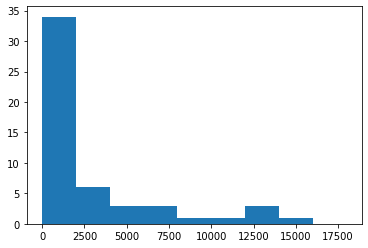

In [20]:
#Network size
plt.hist(df['N'],bins = range(0,20000,2000))

Text(0.5, 1.0, 'Overall: N vs number of communities')

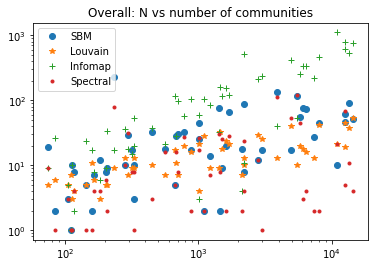

In [160]:
plt.plot(df['N'],df['Community Size-SBM_DC'],"o")
plt.plot(df['N'],df['Community Size-Louvain'],"*")
plt.plot(df['N'],df['Community Size-Infomap'],"+")
plt.plot(df['N'],df['Community Size-Spectral'],".")
plt.xscale('log')
plt.yscale('log')
plt.gca().legend(("SBM","Louvain","Infomap",'Spectral'))
plt.title("Overall: N vs number of communities")

In [67]:
irow = df.index.values.tolist() 
sbm_types = SS.summary(df,'SBM_DC',irow)
lou_types = SS.summary(df,'Louvain',irow)
info_types = SS.summary(df,'Infomap',irow)
spec_types = SS.summary(df,'Spectral',irow)
dngr_types = SS.summary(df,'DNGR',irow)

SBM_DC  Summary:
Among all  50  networks,  SBM_DC  finds  92.0 % networks have non-assortative communities.
Among all  50  networks,  SBM_DC  finds  68.0 % networks have communities with new structures.

For networks with non-assortative community structure, 
   * 84.0 % has core-periphery structure.
   * 54.0 % has disassortative structure.
   * 80.77 % has source-basin structure.

Overall, the most common interaction type is  Assortative  with fraction  80.0 %
Louvain  Summary:
Among all  52  networks,  Louvain  finds  11.54 % networks have non-assortative communities.
Among all  52  networks,  Louvain  finds  5.77 % networks have communities with new structures.

For networks with non-assortative community structure, 
   * 7.69 % has core-periphery structure.
   * 1.92 % has disassortative structure.
   * 7.69 % has source-basin structure.

Overall, the most common interaction type is  Assortative  with fraction  98.08 %
Infomap  Summary:
Among all  50  networks,  Infomap  finds  28

## Dominant community structure type detected by each method

In [26]:
N_di = []
N_di.append(sum(1 for i in irow if df.at[i,'Directed'] and df.at[i,'Community Eligible Size-SBM_DC']>1))
N_di.append(sum(1 for i in irow if df.at[i,'Directed'] and df.at[i,'Community Eligible Size-Louvain']>1))
N_di.append(sum(1 for i in irow if df.at[i,'Directed'] and df.at[i,'Community Eligible Size-Infomap']>1))
N_di.append(sum(1 for i in irow if df.at[i,'Directed'] and df.at[i,'Community Eligible Size-Spectral']>1))
N_di.append(sum(1 for i in irow if df.at[i,'Directed'] and df.at[i,'Community Eligible Size-DNGR']>1))
N_all = []
N_all.append(sum(1 for i in irow if df.at[i,'Community Eligible Size-SBM_DC']>1))
N_all.append(sum(1 for i in irow if df.at[i,'Community Eligible Size-Louvain']>1))
N_all.append(sum(1 for i in irow if df.at[i,'Community Eligible Size-Infomap']>1))
N_all.append(sum(1 for i in irow if df.at[i,'Community Eligible Size-Spectral']>1))
N_all.append(sum(1 for i in irow if df.at[i,'Community Eligible Size-DNGR']>1))

In [27]:
values = []
labels = ["Assortative","Core-Periphery","Disassortative","Source-Basin"]

counter = Counter(sbm_types)
counts = [counter[k]/N_all[0] if k in counter.keys() else 0 for k in labels]
counts[3] = counts[3]*N_all[0]/N_di[0]
values.append(counts)


counter = Counter(lou_types)
counts = [counter[k]/N_all[1] if k in counter.keys() else 0 for k in labels ]
counts[3] = counts[3]*N_all[1]/N_di[1]
values.append(counts)

counter = Counter(info_types)
counts = [counter[k]/N_all[2] if k in counter.keys() else 0 for k in labels ]
counts[3] = counts[3]*N_all[2]/N_di[2]
values.append(counts)


counter = Counter(spec_types)
counts = [counter[k]/N_all[3] if k in counter.keys() else 0 for k in labels ]
counts[3] = counts[3]*N_all[3]/N_di[3]
values.append(counts)

counter = Counter(dngr_types)
counts = [counter[k]/N_all[4] if k in counter.keys() else 0 for k in labels ]
counts[3] = counts[3]*N_all[4]/N_di[4]
values.append(counts)

In [28]:
with open("./Outputs/Case/null_frac.list","rb") as f:
     _,null_dom_frac= pickle.load(f)

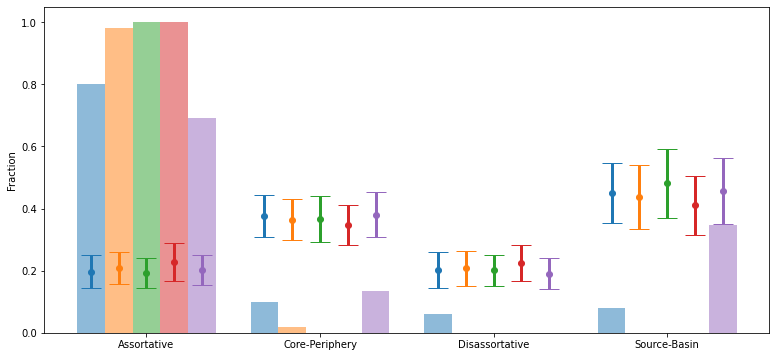

In [30]:
plt.figure(figsize=(13,6))
X = ["Assortative","Core-Periphery","Disassortative","Source-Basin"]
x_axis = np.arange(len(X))
plt.bar(x_axis-0.32, values[0],width = 0.16,alpha = 0.5)
plt.bar(x_axis-0.16, values[1],width = 0.16,alpha = 0.5)
plt.bar(x_axis, values[2],width = 0.16,alpha = 0.5)
plt.bar(x_axis+0.16, values[3],width = 0.16,alpha = 0.5)
plt.bar(x_axis+0.32, values[4],width = 0.16,alpha = 0.5)

plt.errorbar(x_axis-0.32,np.mean(null_dom_frac['SBM_DC'],axis = 1),yerr=np.std(null_dom_frac['SBM_DC'],axis = 1),fmt='o',elinewidth=3,color = colors[0],capsize = 10)
plt.errorbar(x_axis-0.16,np.mean(null_dom_frac['Louvain'],axis = 1),yerr=np.std(null_dom_frac['Louvain'],axis = 1),fmt='o',elinewidth=3,color = colors[1],capsize = 10)
plt.errorbar(x_axis,np.mean(null_dom_frac['Infomap'],axis = 1),yerr=np.std(null_dom_frac['Infomap'],axis = 1),fmt='o',elinewidth=3,color = colors[2],capsize = 10)
plt.errorbar(x_axis+0.16,np.mean(null_dom_frac["Spectral"],axis = 1),yerr=np.std(null_dom_frac["Spectral"],axis = 1),fmt='o',elinewidth=3,color = colors[3],capsize = 10)
plt.errorbar(x_axis+0.32,np.mean(null_dom_frac["DNGR"],axis = 1),yerr=np.std(null_dom_frac["DNGR"],axis = 1),fmt='o',elinewidth=3,color = colors[4],capsize = 10)



plt.xticks(x_axis, X)
# plt.gca().legend(("SBM","Louvain","Infomap","Spectral","DNGR"))
plt.ylabel('Fraction')
# plt.grid(axis='y', alpha=0.75)
# plt.axis('off')

plt.show()

## Propotional Occurrence TYPE 

In [31]:
sbm_occ_frac_types = {"Assortative":[],"Core-Periphery":[],"Disassortative":[],"Source-Basin":[]}
lou_occ_frac_types = {"Assortative":[],"Core-Periphery":[],"Disassortative":[],"Source-Basin":[]}
info_occ_frac_types = {"Assortative":[],"Core-Periphery":[],"Disassortative":[],"Source-Basin":[]}
spec_occ_frac_types = {"Assortative":[],"Core-Periphery":[],"Disassortative":[],"Source-Basin":[]}#for each method: SBM_DC, Louvain, Infomap, Spectral
dngr_occ_frac_types = {"Assortative":[],"Core-Periphery":[],"Disassortative":[],"Source-Basin":[]}#for each method: SBM_DC, Louvain, Infomap, Spectral


for i in irow:
    method = 'SBM_DC'
    col_name = 'Interaction Fraction-'+method
    if df.at[i,'Community Eligible Size-'+method] > 1:
        types = ast.literal_eval(df.at[i,col_name])
        for key in types.keys():
            sbm_occ_frac_types[key].append(types[key])
            
    method = 'Louvain'
    col_name = 'Interaction Fraction-'+method
    if df.at[i,'Community Eligible Size-'+method] > 1:
        types = ast.literal_eval(df.at[i,col_name])
        for key in types.keys():
            lou_occ_frac_types[key].append(types[key])
            
    method = 'Infomap'
    col_name = 'Interaction Fraction-'+method
    if df.at[i,'Community Eligible Size-'+method] > 1:
        types = ast.literal_eval(df.at[i,col_name])
        for key in types.keys():
            info_occ_frac_types[key].append(types[key])
    
    method = 'Spectral'
    col_name = 'Interaction Fraction-'+method
    if df.at[i,'Community Eligible Size-'+method] > 1:
        types = ast.literal_eval(df.at[i,col_name])
        for key in types.keys():
            spec_occ_frac_types[key].append(types[key])
    
    method = 'DNGR'
    col_name = 'Interaction Fraction-'+method
    if df.at[i,'Community Eligible Size-'+method] > 1:
        types = ast.literal_eval(df.at[i,col_name])
        for key in types.keys():
            dngr_occ_frac_types[key].append(types[key])

values = []
labels = ["Assortative","Core-Periphery","Disassortative","Source-Basin"]


counts = [sum(sbm_occ_frac_types[k])/N_all[0] for k in labels]
counts[3] = counts[3]*N_all[0]/N_di[0]
values.append(counts)


counts = [sum(lou_occ_frac_types[k])/N_all[1] for k in labels]
counts[3] = counts[3]*N_all[1]/N_di[1]
values.append(counts)

counts = [sum(info_occ_frac_types[k])/N_all[2] for k in labels]
counts[3] = counts[3]*N_all[2]/N_di[2]
values.append(counts)


counts = [sum(spec_occ_frac_types[k])/N_all[3] for k in labels]
counts[3] = counts[3]*N_all[3]/N_di[3]
values.append(counts)
 
counts = [sum(dngr_occ_frac_types[k])/N_all[4] for k in labels]
counts[3] = counts[3]*N_all[4]/N_di[4]
values.append(counts)

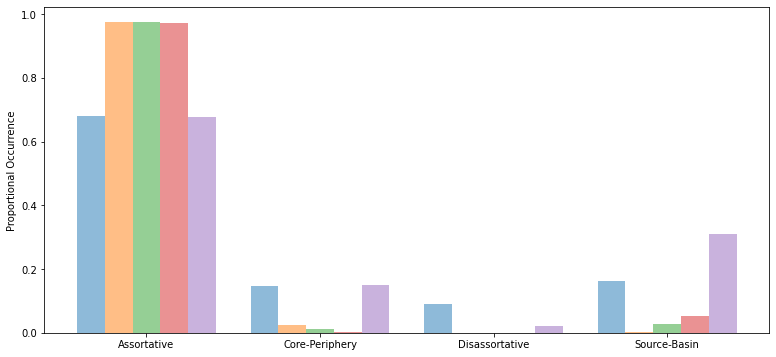

In [32]:
plt.figure(figsize=(13,6))
X = ['Assortative','Core-Periphery',"Disassortative","Source-Basin"]
x_axis = np.arange(len(X))
plt.bar(x_axis-0.32, values[0],width = 0.16,alpha = 0.5)
plt.bar(x_axis-0.16, values[1],width = 0.16,alpha = 0.5)
plt.bar(x_axis, values[2],width = 0.16,alpha = 0.5)
plt.bar(x_axis+0.16, values[3],width = 0.16,alpha = 0.5)
plt.bar(x_axis+0.32, values[4],width = 0.16,alpha = 0.5)


plt.xticks(x_axis, X)
# plt.gca().legend(("SBM","Louvain","Infomap","Spectral","DNGR"))
plt.ylabel('Proportional Occurrence')
plt.show()

## Occurring TYPE

In [33]:
sbm_occ_types,lou_occ_types,info_occ_types,spec_occ_types,dngr_occ_types = [],[],[],[],[] #for each method: SBM_DC, Louvain, Infomap, Spectral

for i in irow:
    method = 'SBM_DC'
    col_name = 'Interaction Fraction-'+method
    if df.at[i,'Community Eligible Size-'+method] > 1:
        sbm_occ_types.extend([key for key in ast.literal_eval(df.at[i,col_name]).keys()])
            
    method = 'Louvain'
    col_name = 'Interaction Fraction-'+method
    if df.at[i,'Community Eligible Size-'+method] > 1:
        lou_occ_types.extend([key for key in ast.literal_eval(df.at[i,col_name]).keys()])
            
    method = 'Infomap'
    col_name = 'Interaction Fraction-'+method
    if df.at[i,'Community Eligible Size-'+method] > 1:
        info_occ_types.extend([key for key in ast.literal_eval(df.at[i,col_name]).keys()])
            
    method = 'Spectral'
    col_name = 'Interaction Fraction-'+method
    if df.at[i,'Community Eligible Size-'+method] > 1:
        spec_occ_types.extend([key for key in ast.literal_eval(df.at[i,col_name]).keys()])
        
    method = 'DNGR'
    col_name = 'Interaction Fraction-'+method
    if df.at[i,'Community Eligible Size-'+method] > 1:
        dngr_occ_types.extend([key for key in ast.literal_eval(df.at[i,col_name]).keys()])

values = []
labels = ["Assortative","Core-Periphery","Disassortative","Source-Basin"]

counter = Counter(sbm_occ_types)
counts = [counter[k]/N_all[0] if k in counter.keys() else 0 for k in labels]
counts[3] = counts[3]*N_all[0]/N_di[0]
values.append(counts)


counter = Counter(lou_occ_types)
counts = [counter[k]/N_all[1] if k in counter.keys() else 0 for k in labels ]
counts[3] = counts[3]*N_all[1]/N_di[1]
values.append(counts)

counter = Counter(info_occ_types)
counts = [counter[k]/N_all[2] if k in counter.keys() else 0 for k in labels ]
counts[3] = counts[3]*N_all[2]/N_di[2]
values.append(counts)


counter = Counter(spec_occ_types)
counts = [counter[k]/N_all[3] if k in counter.keys() else 0 for k in labels ]
counts[3] = counts[3]*N_all[3]/N_di[3]
values.append(counts)
   
counter = Counter(dngr_occ_types)
counts = [counter[k]/N_all[4] if k in counter.keys() else 0 for k in labels ]
counts[3] = counts[3]*N_all[4]/N_di[4]
values.append(counts)

In [34]:
with open("./Outputs/Case/null_frac.list","rb") as f:
    null_occ_frac,_ = pickle.load(f)

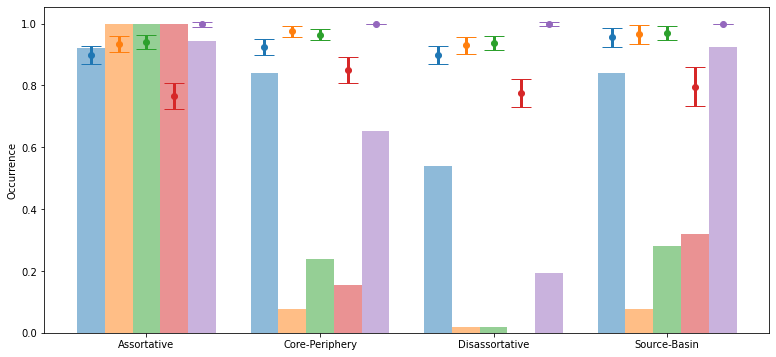

In [35]:
plt.figure(figsize=(13,6))
X = ['Assortative','Core-Periphery',"Disassortative","Source-Basin"]
x_axis = np.arange(len(X))
plt.bar(x_axis-0.32, values[0],width = 0.16,alpha = 0.5)
plt.bar(x_axis-0.16, values[1],width = 0.16,alpha = 0.5)
plt.bar(x_axis, values[2],width = 0.16,alpha = 0.5)
plt.bar(x_axis+0.16, values[3],width = 0.16,alpha = 0.5)
plt.bar(x_axis+0.32, values[4],width = 0.16,alpha = 0.5)

plt.errorbar(x_axis-0.32,np.mean(null_occ_frac['SBM_DC'],axis = 1),yerr=np.std(null_occ_frac['SBM_DC'],axis = 1),fmt='o',elinewidth=3,color = colors[0],capsize = 10)
plt.errorbar(x_axis-0.16,np.mean(null_occ_frac['Louvain'],axis = 1),yerr=np.std(null_occ_frac['Louvain'],axis = 1),fmt='o',elinewidth=3,color = colors[1],capsize = 10)
plt.errorbar(x_axis,np.mean(null_occ_frac['Infomap'],axis = 1),yerr=np.std(null_occ_frac['Infomap'],axis = 1),fmt='o',elinewidth=3,color = colors[2],capsize = 10)
plt.errorbar(x_axis+0.16,np.mean(null_occ_frac["Spectral"],axis = 1),yerr=np.std(null_occ_frac["Spectral"],axis = 1),fmt='o',elinewidth=3,color = colors[3],capsize = 10)
plt.errorbar(x_axis+0.32,np.mean(null_occ_frac["DNGR"],axis = 1),yerr=np.std(null_occ_frac["DNGR"],axis = 1),fmt='o',elinewidth=3,color = colors[4],capsize = 10)



plt.xticks(x_axis, X)
# plt.gca().legend(("SBM_DC","Louvain","Infomap","Spectral"))
plt.ylabel('Occurrence')
plt.show()

## Non-Assortative Fraction of Each Category

In [70]:
def non_Ass_prop(df,irow,method,category):
    col_name = 'Interaction Fraction-'+method
    non_prop = []
    N = []
    B = []
    for i in irow:
        if df.at[i,'Category'] == category:
            if type(ast.literal_eval(df.at[i,col_name])) == dict:
                value = ast.literal_eval(df.at[i,col_name])
                if "Assortative" in value.keys():
                    non_prop.append(1-value['Assortative'])
                    
                else:
                    non_prop.append(1)
                dom = max(value, key=value.get)
#                 if dom != "Assortative":
#                     print(method,df.at[i,'Community Eligible Size-'+method],dom,non_prop[-1])
#                 else:
#                     if non_prop[-1] >0.5:
#                         print(method,df.at[i,'Community Eligible Size-'+method],non_prop[-1])
            else:
                non_prop.append(-1)
            B.append(df.at[i,'Community Eligible Size-'+method])
            N.append(df.at[i,'N'])
    return B,N,non_prop;


def single_structure_prop(df,irow,method,category,structure):
    col_name = 'Interaction Fraction-'+method
    non_prop = []
    N = []
    for i in irow:
        if df.at[i,'Category'] == category:
            if type(ast.literal_eval(df.at[i,col_name])) == dict:
                value = ast.literal_eval(df.at[i,col_name])
                if structure in value.keys():
                    non_prop.append(value[structure])
                else:
                    non_prop.append(0)
            else:
                non_prop.append(-1)
#             N.append(df.at[i,'Community Eligible Size-'+method])
            N.append(df.at[i,'N'])
    return N,non_prop;

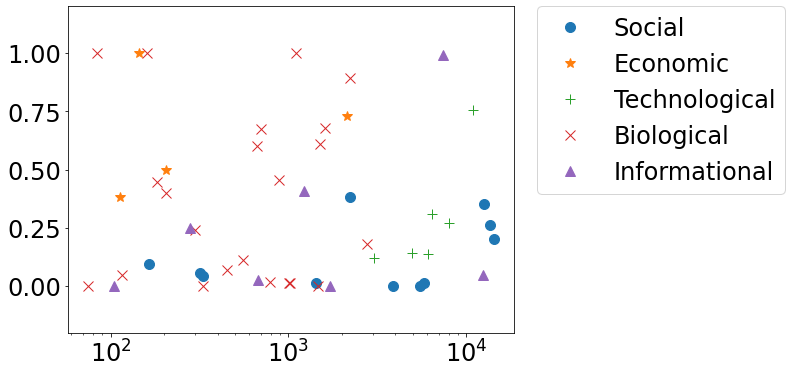

In [10]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(8,6))
_,N,non_prop = non_Ass_prop(df,irow,'SBM_DC','Social')
plt.plot(N,non_prop,"o", markersize=10)
_,N,non_prop = non_Ass_prop(df,irow,'SBM_DC','Economic')
plt.plot(N,non_prop,"*", markersize=10)
_,N,non_prop = non_Ass_prop(df,irow,'SBM_DC','Technological')
plt.plot(N,non_prop,"+", markersize=10)
_,N,non_prop = non_Ass_prop(df,irow,'SBM_DC','Biological')
plt.plot(N,non_prop,"x", markersize=10)
_,N,non_prop = non_Ass_prop(df,irow,'SBM_DC','Informational')
plt.plot(N,non_prop,"^", markersize=10)

plt.xscale('log')
plt.ylim(-0.2,1.2)

plt.gca().legend(("Social","Economic","Technological",'Biological','Informational'),bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
# plt.title("Overall: N vs Fraction of non-Assortative type")

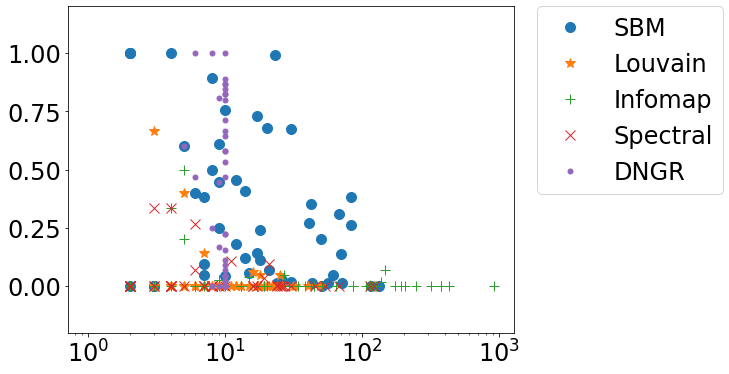

In [73]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(8,6))
N,non_prop = [],[]
x1,_,x3 = non_Ass_prop(df,irow,'SBM_DC','Social')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'SBM_DC','Economic')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'SBM_DC','Technological')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'SBM_DC','Biological')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'SBM_DC','Informational')
N.extend(x1)
non_prop.extend(x3)

plt.plot(N,non_prop,"o", markersize=10)

N,non_prop = [],[]
x1,_,x3 = non_Ass_prop(df,irow,'Louvain','Social')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Louvain','Economic')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Louvain','Technological')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Louvain','Biological')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Louvain','Informational')
N.extend(x1)
non_prop.extend(x3)

plt.plot(N,non_prop,"*", markersize=10)

N,non_prop = [],[]
x1,_,x3 = non_Ass_prop(df,irow,'Infomap','Social')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Infomap','Economic')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Infomap','Technological')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Infomap','Biological')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Infomap','Informational')
N.extend(x1)
non_prop.extend(x3)

plt.plot(N,non_prop,"+", markersize=10)

N,non_prop = [],[]
x1,_,x3 = non_Ass_prop(df,irow,'Spectral','Social')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Spectral','Economic')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Spectral','Technological')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Spectral','Biological')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'Spectral','Informational')
N.extend(x1)
non_prop.extend(x3)

plt.plot(N,non_prop,"x", markersize=10)

N,non_prop = [],[]
x1,_,x3 = non_Ass_prop(df,irow,'DNGR','Social')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'DNGR','Economic')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'DNGR','Technological')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'DNGR','Biological')
N.extend(x1)
non_prop.extend(x3)
x1,_,x3 = non_Ass_prop(df,irow,'DNGR','Informational')
N.extend(x1)
non_prop.extend(x3)

plt.plot(N,non_prop,".", markersize=10)


plt.xscale('log')
plt.ylim(-0.2,1.2)

plt.gca().legend(("SBM","Louvain","Infomap",'Spectral','DNGR'),bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
# plt.title("Overall: N vs Fraction of non-Assortative type")

([<matplotlib.axis.XTick at 0x167aa5640>,
 [Text(1, 0, 'Social'),
  Text(2, 0, 'Economic'),
  Text(3, 0, 'Technological'),
  Text(4, 0, 'Biological'),
  Text(5, 0, 'Informational')])

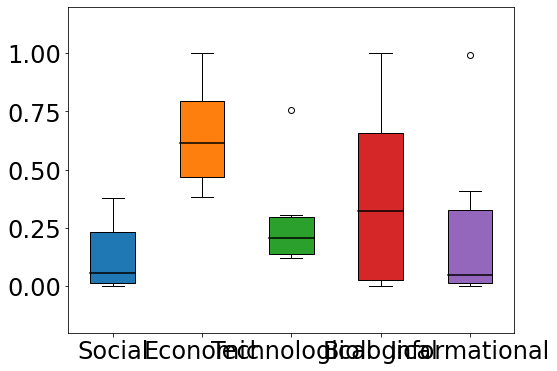

In [15]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(8,6))
data = []
N,non_prop = non_Ass_prop(df,irow,'SBM_DC','Social')
non_prop2 = [i for i in non_prop if i != -1]
data.append(non_prop2)
N,non_prop = non_Ass_prop(df,irow,'SBM_DC','Economic')
non_prop2 = [i for i in non_prop if i != -1]
data.append(non_prop2)
N,non_prop = non_Ass_prop(df,irow,'SBM_DC','Technological')
non_prop2 = [i for i in non_prop if i != -1]
data.append(non_prop2)
N,non_prop = non_Ass_prop(df,irow,'SBM_DC','Biological')
non_prop2 = [i for i in non_prop if i != -1]
data.append(non_prop2)
N,non_prop = non_Ass_prop(df,irow,'SBM_DC','Informational')
non_prop2 = [i for i in non_prop if i != -1]
data.append(non_prop2)

medianprops = dict(color="black",linewidth=1.5)
box = plt.boxplot(data, patch_artist=True,medianprops=medianprops)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(-0.2,1.2)
plt.xticks(range(1,6),["Social","Economic","Technological",'Biological','Informational'])

### Null Model

We compare interaction fraction of empirical networks with null model:
* create a BxB density matrix with numbers $[1,B^2]$ randomly assigned (if undirected, we do one more step: $\omega_{ji} = \omega_{ij}$)
* compute BxB interaction structure matrix $U$ or $D$
* Store result
* repeat above steps k times

For our analysis, we focus on dominant community structure (that has highest prevalence) and occuring community structure (that has non-zero prevalence).

In [ ]:
from Null import *

Compare with empirical datasets
* For each dataset, for each method: compute null model once
* repeat above steps k times

In [171]:
%%time
null_occ_frac = {'SBM_DC':[[],[],[],[]],'Louvain':[[],[],[],[]],'Infomap':[[],[],[],[]],
                'Spectral':[[],[],[],[]],'DNGR':[[],[],[],[]]}#for each method #for each category
null_dom_frac = {'SBM_DC':[[],[],[],[]],'Louvain':[[],[],[],[]],'Infomap':[[],[],[],[]],
                'Spectral':[[],[],[],[]],'DNGR':[[],[],[],[]]}#for each method #for each category
N_di = []
N_di.append(sum(1 for i in irow if df.at[i,'Directed'] and df.at[i,'Community Eligible Size-SBM_DC']>1))
N_di.append(sum(1 for i in irow if df.at[i,'Directed'] and df.at[i,'Community Eligible Size-Louvain']>1))
N_di.append(sum(1 for i in irow if df.at[i,'Directed'] and df.at[i,'Community Eligible Size-Infomap']>1))
N_di.append(sum(1 for i in irow if df.at[i,'Directed'] and df.at[i,'Community Eligible Size-Spectral']>1))
N_di.append(sum(1 for i in irow if df.at[i,'Directed'] and df.at[i,'Community Eligible Size-DNGR']>1))
N_all = []
N_all.append(sum(1 for i in irow if df.at[i,'Community Eligible Size-SBM_DC']>1))
N_all.append(sum(1 for i in irow if df.at[i,'Community Eligible Size-Louvain']>1))
N_all.append(sum(1 for i in irow if df.at[i,'Community Eligible Size-Infomap']>1))
N_all.append(sum(1 for i in irow if df.at[i,'Community Eligible Size-Spectral']>1))
N_all.append(sum(1 for i in irow if df.at[i,'Community Eligible Size-DNGR']>1))

methods = ['SBM_DC','Louvain','Infomap','Spectral','DNGR']
for N in range(100):
    occuring = [[],[],[],[],[]]
    dominant = [[],[],[],[],[]]
    
    for i in irow:
        directed = df.at[i,'Directed']
        for method in methods:
            j = methods.index(method)
            col_name = 'Community Eligible Size-'+method
            B = df.at[i,col_name]
            if B >1:
                realization = null_model(B,1,directed)
                occ_type = get_occuring_type(realization)
                count = Counter(occ_type)
                for key in count.keys():
                    occuring[j].append(key)
                dominant[j].append(get_dominant_type(realization)[0])

                   
    for method in methods:#for each method
        i = methods.index(method)
        null_occ_frac[method][0].append(occuring[i].count("Assortative")/N_all[i])
        null_occ_frac[method][1].append(occuring[i].count("Core-Periphery")/N_all[i])
        null_occ_frac[method][2].append(occuring[i].count("Disassortative")/N_all[i])
        null_occ_frac[method][3].append(occuring[i].count("Source-Basin")/N_di[i])
        
        null_dom_frac[method][0].append(dominant[i].count("Assortative")/N_all[i])
        null_dom_frac[method][1].append(dominant[i].count("Core-Periphery")/N_all[i])
        null_dom_frac[method][2].append(dominant[i].count("Disassortative")/N_all[i])
        null_dom_frac[method][3].append(dominant[i].count("Source-Basin")/N_di[i])

CPU times: user 7min 27s, sys: 2.08 s, total: 7min 29s
Wall time: 7min 29s


In [172]:
with open("./Outputs/Case/null_frac.list","wb") as f:
    pickle.dump([null_occ_frac,null_dom_frac],f)

# Case Study

We analysed two social networks to gain deeper understanding of our newly finding type: Source-Basin.

One network is political blogs from a well-known paper [] and another one is constructed ourselves relating with a political debate in Twitter about bushfire in 2019/2020

## Polblogs

In [60]:
G_gt = gt.collection.data["polblogs"] 
G_gt = preprocess(G_gt,graph_type = 'gt')
G_nx = convert_gt_to_nx(G_gt, vp_name="title",ep_name=None)

In [21]:
print(G_gt)

<Graph object, directed, with 1222 vertices and 19086 edges, 5 internal vertex properties, 2 internal graph properties, at 0x167b4ea30>


Try SBM with number of groups specified from 2 to 14

In [46]:
%%time
SBM_B_par = {}
ep_name = None
for B in range(2,15):
    sbm_par =GM.detect_community(G_gt,method = "SBM",ep_name = ep_name)
    spar = SS.sort_par(sbm_par)
    SBM_B_par['B='+str(B)] = list(map(lambda x: spar[x], sbm_par))

CPU times: user 4min 3s, sys: 14.7 s, total: 4min 18s
Wall time: 4min 18s


In [65]:
with open("./Outputs/Case/polblogs_SBM_B.par","wb") as f:
    pickle.dump(SBM_B_par,f)

In [61]:
with open("./Outputs/Case/polblogs_SBM_B.par","rb") as f:
    SBM_B_par = pickle.load(f)

In [23]:
value = [G_gt.vp['value'][v] for v in G_gt.vertices()]
SBM_B_par['value']=value
df = pd.DataFrame (SBM_B_par, columns = ['B=2','B=3','B=4','B=5','B=6','B=7','B=8','B=9','B=10','B=11','B=12','B=13','B=14','value','blog'])

node label:
0: liberal 1:conservative

###### B = 2

Reliable community number:  2
sbm_dc  has prevalence: {'Assortative': 1.0}


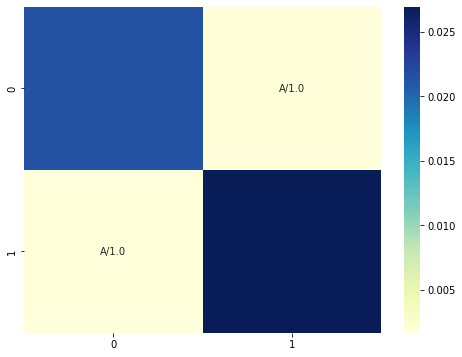

In [145]:
vp_name = 'title'
d = SS.summary_case(G_gt,SBM_B_par['B=2'],'sbm_dc',node_order=[G_gt.vp[vp_name][v] for v in G_gt.vertices()],vp_name="title",reverse_dir = True,fig_size=(8, 6))

In [133]:
pd.crosstab(df['B=2'],df.value)

value,0.0,1.0
B=2,,
0,44,621
1,542,15


We see that community 0 has more "1"s(conservative) while community 1 has more "0"s(liberal). Also, the certainty scores are all 1 which means the community structure type is always classified as Assortative during 100 boostrapping interations.

Reliable community number:  3
sbm_dc  has prevalence: {'Assortative': 1.0}


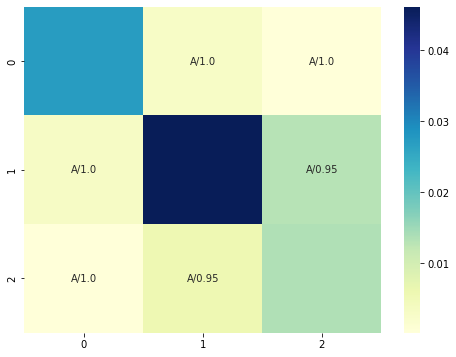

In [146]:
vp_name = 'title'
d = SS.summary_case(G_gt,SBM_B_par['B=3'],'sbm_dc',node_order=[G_gt.vp[vp_name][v] for v in G_gt.vertices()],vp_name="title",reverse_dir = True,fig_size=(8, 6))

In [51]:
pd.crosstab(df['B=3'],df.value)

value,0.0,1.0
B=3,,
0,539,15
1,28,339
2,19,282


Reliable community number:  4
sbm_dc  has prevalence: {'Assortative': 0.6666666666666666, 'Core-Periphery': 0.3333333333333333}


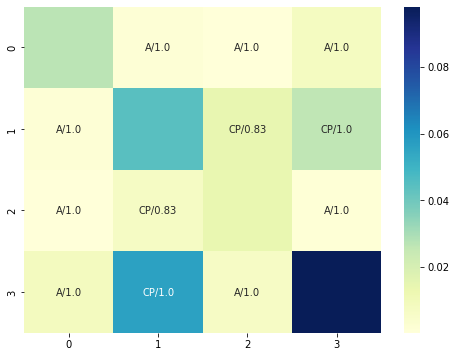

In [147]:
d = SS.summary_case(G_gt,SBM_B_par['B=4'],'sbm_dc',node_order=[G_gt.vp[vp_name][v] for v in G_gt.vertices()],vp_name="title",reverse_dir = True,fig_size=(8, 6))

In [53]:
pd.crosstab(df['B=4'],df.value)

value,0.0,1.0
B=4,,
0,541,16
1,5,288
2,19,273
3,21,59


Reliable community number:  5
sbm_dc  has prevalence: {'Assortative': 0.7, 'Core-Periphery': 0.2, 'Source-Basin': 0.1}


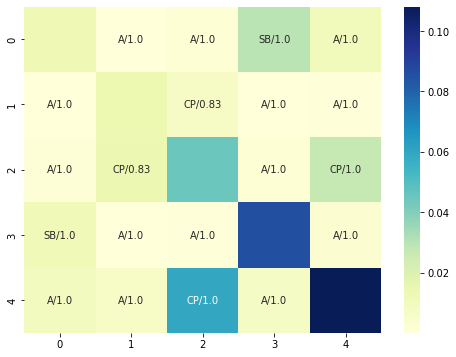

In [62]:
d = SS.summary_case(G_gt,SBM_B_par['B=5'],'sbm_dc',node_order=[G_gt.vp[vp_name][v] for v in G_gt.vertices()],vp_name="title",reverse_dir = True,fig_size=(8, 6))

In [131]:
d[np.ix_([0,3],[0,3])]

array([[0.01239577, 0.02923056],
       [0.0113936 , 0.08603326]])

In [28]:
pd.crosstab(df['B=5'],df.value)

value,0.0,1.0
B=5,,
0,341,13
1,18,273
2,4,287
3,205,5
4,18,58


In [112]:
pd.crosstab(df['B=2'],df['B=3'])

B=3,0,1,2
B=2,,,
0,2,362,301
1,552,5,0


In [113]:
pd.crosstab(df['B=3'],df['B=4'])

B=4,0,1,2,3
B=3,,,,
0,554,0,0,0
1,2,280,5,80
2,1,13,287,0


In [114]:
pd.crosstab(df['B=4'],df['B=5'])

B=5,0,1,2,3,4
B=4,,,,,
0,347,0,0,210,0
1,3,0,290,0,0
2,2,290,0,0,0
3,2,1,1,0,76


## Climate retweet 

In [38]:
G_gt = gt.load_graph("./Data/Case/Climate.xml.gz")
G_gt = preprocess(G_gt,"./Data/Case/Climate.xml.gz")
G_nx = convert_gt_to_nx(G_gt, vp_name="title",ep_name=None)
print(G_gt)

<Graph object, directed, with 4029 vertices and 429235 edges, 3 internal vertex properties, 1 internal edge property, at 0x174193e20>


try DC-SBM with number of groups specified from 2 to 10

In [10]:
%%time
SBM_B_par = {}
ep_name = None
for B in range(2,11):
    sbm_par =detect_community(G_gt,method = "SBM",ep_name = ep_name)
    spar = SS.sort_par(sbm_par)
    SBM_B_par['B='+str(B)] = list(map(lambda x: spar[x], sbm_par))

CPU times: user 2h 6min 43s, sys: 3min 35s, total: 2h 10min 19s
Wall time: 2h 10min 19s


In [11]:
with open("./Outputs/Case/Climate_SBM_B.par","wb") as f:
    pickle.dump(SBM_B_par,f)

In [39]:
with open("./Outputs/Case/Climate_SBM_B.par","rb") as f:
    SBM_B_par = pickle.load(f)

In [40]:
vp_name = 'title'

Reliable community number:  2
sbm_dc  has prevalence: {'Assortative': 1.0}


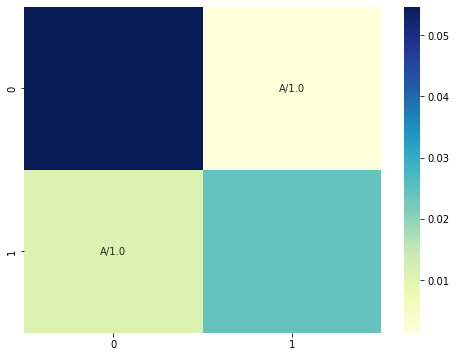

In [47]:
d = SS.summary_case(G_gt,SBM_B_par['B=2'],'sbm_dc',node_order=[G_gt.vp[vp_name][v] for v in G_gt.vertices()],vp_name="title",reverse_dir = False,fig_size=(8, 6))

In [58]:
pd.crosstab(df['B=2'],df.arson_value)

arson_value,N/A,Oppose,Support
B=2,,,
0,2389,26,0
1,1585,4,25


In [59]:
pd.crosstab(df['B=2'],df.climate_value)

climate_value,N/A,Oppose,Support
B=2,,,
0,2202,14,199
1,1573,25,16


Reliable community number:  3
sbm_dc  has prevalence: {'Assortative': 1.0}
CPU times: user 9min 58s, sys: 6min 1s, total: 16min
Wall time: 11min 30s


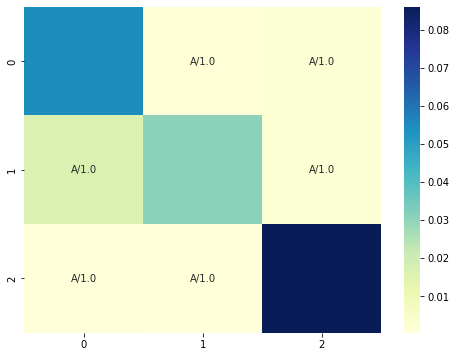

In [48]:
%%time
d = SS.summary_case(G_gt,SBM_B_par['B=3'],'sbm_dc',node_order=[G_gt.vp[vp_name][v] for v in G_gt.vertices()],vp_name="title",reverse_dir = False,fig_size=(8, 6))

In [56]:
pd.crosstab(df['B=3'],df.arson_value)

arson_value,N/A,Oppose,Support
B=3,,,
0,2389,26,0
1,1044,4,0
2,541,0,25


In [57]:
pd.crosstab(df['B=3'],df.climate_value)

climate_value,N/A,Oppose,Support
B=3,,,
0,2200,14,201
1,1036,2,10
2,539,23,4


Reliable community number:  4
sbm_dc  has prevalence: {'Assortative': 0.8333333333333334, 'Source-Basin': 0.16666666666666666}
CPU times: user 9min 56s, sys: 6min 5s, total: 16min 1s
Wall time: 11min 21s


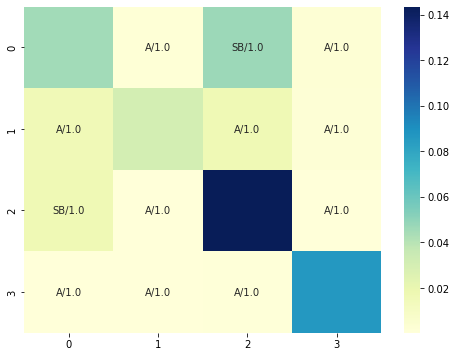

In [49]:
%%time
d = SS.summary_case(G_gt,SBM_B_par['B=4'],'sbm_dc',node_order=[G_gt.vp[vp_name][v] for v in G_gt.vertices()],vp_name="title",reverse_dir = False,fig_size=(8, 6))

In [54]:
pd.crosstab(df['B=4'],df.arson_value)

arson_value,N/A,Oppose,Support
B=4,,,
0,1460,14,0
1,1030,4,0
2,945,12,0
3,539,0,25


In [55]:
pd.crosstab(df['B=4'],df.climate_value)

climate_value,N/A,Oppose,Support
B=4,,,
0,1361,9,104
1,1022,2,10
2,855,5,97
3,537,23,4


In [50]:
df_arson = pd.read_csv('./Outputs/Case/climate_classifications_arson.csv',header=0, 
            names=['Node', 'Classification'])
df_climate = pd.read_csv('../Outputs/Case/climate_classifications_climate.csv',header=0, 
            names=['Node', 'Classification'])

In [51]:
irow = df_arson.index.values.tolist() 
arson = {}
for i in irow:
    if df_arson.at[i,'Classification'] in ['Oppose','Support']:
        arson[str(df_arson.at[i,'Node'])] = df_arson.at[i,'Classification']
irow = df_climate.index.values.tolist() 
climate = {}
for i in irow:
    if df_climate.at[i,'Classification'] in ['Link','Reject denial']:
        climate[str(df_climate.at[i,'Node'])] = 'Support'
    elif df_climate.at[i,'Classification'] in ['Denial','Reject link']: 
        climate[str(df_climate.at[i,'Node'])] = 'Oppose'    

In [52]:
arson_value = [arson[G_gt.vp.name[v]] if G_gt.vp.name[v] in arson.keys() else 'N/A' for v in G_gt.vertices()]
climate_value = [climate[G_gt.vp.name[v]] if G_gt.vp.name[v] in climate.keys() else 'N/A' for v in G_gt.vertices()]

In [53]:
SBM_B_par['arson_value']=arson_value
SBM_B_par['climate_value']=climate_value
SBM_B_par['Node']=[G_gt.vp.name[v] for v in G_gt.vertices()]
df = pd.DataFrame (SBM_B_par, columns = ['Node','B=2','B=3','B=4','B=5','arson_value','climate_value'])